In [1]:
import pandas as pd
import datetime
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
#from lime import lime_tabular

In [139]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# read in master file
df_orig=pd.read_excel("master_file_4.xlsx")
# exclude planned delays
df_orig=df_orig[df_orig['Category_x']!='Planned Delay 3']
df_orig=df_orig[df_orig['Category_x']!='planned Delay 3']
# Correcting Standard 2 = Standard 3
df_orig = df_orig.replace({'Category_x': {'Standard 2': 'Standard 3', 
                                'Urgent ICU/SDU 2':'Urgent 2'}})

In [4]:
# read in instance file
df_ins = pd.read_excel("instance_20200109.xlsx", sheet_name='Sheet2')


## ML models

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

### data to train model

In [6]:
df_orig['TxApptBook-Sim']=pd.to_datetime(df_orig['TxApptCreatedDt']).dt.date-pd.to_datetime(df_orig['SimApptDt']).dt.date
df_orig['TxApptBook-Sim']=df_orig['TxApptBook-Sim'].dt.days

In [7]:
### most recent 6-month data
#df1920 = df_orig[pd.to_datetime(df_orig['CreatedDate']).dt.year>=2019]
df1920 = df_orig[(pd.to_datetime(df_orig['CreatedDate']).dt.date >= pd.to_datetime("2019-06-01"))&
                (pd.to_datetime(df_orig['CreatedDate']).dt.date <= pd.to_datetime("2019-12-31"))]
df1920.size


207504

In [138]:
'''df_forins = df_orig[(pd.to_datetime(df_orig['CreatedDate']).dt.date >= pd.to_datetime("2019-06-01"))&
                (pd.to_datetime(df_orig['CreatedDate']).dt.date <= pd.to_datetime("2021-12-31"))]
df_forins.to_excel("master_2019-2020.xlsx")'''

In [403]:
df1920['TimeBtw_Sim_BkTx'] = df1920.apply(
    lambda row: row['ContourDur'] if row['TimeBtw_Sim_BkTx']<0 else row['TimeBtw_Sim_BkTx'],
    axis=1
)
df1920["TimeBtw_Sim_BkTx"] = df1920["TimeBtw_Sim_BkTx"].fillna(df1920["TimeBtw_Sim_BkTx"].mode())

### contouring

In [404]:
target_y = "TimeBtw_Sim_BkTx"
df_meet = df1920[df1920['WaitTime']<=14]
features = ['Sitegroup_y', 'Category_x', 'TltDose', 'TxFracs']
df_clf = df_meet[features + [target_y]]


In [405]:
df_clf["Sitegroup_y"] = df_clf["Sitegroup_y"].fillna(df_clf["Sitegroup_y"].mode()[0])
#df_clf["Category_x"] = df_clf["Category_x"].fillna(df_clf["Category_x"].mode())
df_clf["TltDose"] = df_clf["TltDose"].fillna(df_clf["TltDose"].mode()[0])
df_clf["TxFracs"] = df_clf["TxFracs"].fillna(df_clf["TxFracs"].mode()[0])
df_clf[target_y] = df_clf[target_y].fillna(df_clf[target_y].mode()[0])

In [406]:
dummy = pd.get_dummies(df_clf[["Sitegroup_y","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_cont = pd.concat([df_clf, dummy], axis=1)
#print( df_clf.filter(like="Sitegroup_y",axis=1).head() )

## drop the original categorical column
df_cont = df_cont.drop(['Sitegroup_y','Category_x'], axis=1)

In [407]:
# train-test spli4
df_train, df_test = model_selection.train_test_split(df_cont, test_size=0.3, random_state=4)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())

X_train shape: (1080, 20) | X_test shape: (464, 20)
y_train mean: 1.76 | y_test mean: 1.69
21 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GASTROINTESTINAL(GI)', 'Site_GENITOURINARY(GU)', 'Site_GYNAE', 'Site_LEUKEMIA', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Site_UNKNOWN', 'Categ_Emergency 1', 'Categ_Standard 3', 'Categ_Urgent 2']


In [408]:
df_test_copy = df_test

In [409]:
# 0-1, class 0; 2-5, class 1, >5, class 2
df_train.loc[df_train[target_y] <=1, 'ContourGroup'] = 0
df_train.loc[(df_train[target_y] <=4)&(df_train[target_y]>=2), 'ContourGroup'] = 1
df_train.loc[df_train[target_y] >= 5, 'ContourGroup'] = 2
df_train = df_train.drop(columns=[target_y])

df_test.loc[df_test[target_y] <= 1, 'ContourGroup'] = 0
df_test.loc[(df_test[target_y] <= 4)&(df_test[target_y]>=2), 'ContourGroup'] = 1
df_test.loc[df_test[target_y] >= 5, 'ContourGroup'] = 2
df_test = df_test.drop(columns=[target_y])

In [410]:
X_train = df_train.drop('ContourGroup', axis=1).values
y_train = df_train['ContourGroup'].values

X_test = df_test.drop('ContourGroup', axis=1).values
y_test = df_test['ContourGroup'].values
feature_names = df_train.drop('ContourGroup', axis=1).columns.tolist()

In [411]:
### Random Forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_train,y_train)

y_pred = clf_rf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7068965517241379


In [412]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [10, 12, 15],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [413]:
# evaluate random search
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [414]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X_test, y_test)

#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [415]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 300}

In [416]:
grid_search.score(X_test, y_test)

0.709051724137931

In [417]:
y_rf_pred=grid_search.predict(X_test)
cm_rf = confusion_matrix(y_test, y_rf_pred)
print(cm_rf)
print(classification_report(y_test, y_rf_pred))

[[264  27   1]
 [ 49  57   6]
 [ 25  27   8]]
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84       292
         1.0       0.51      0.51      0.51       112
         2.0       0.53      0.13      0.21        60

    accuracy                           0.71       464
   macro avg       0.61      0.52      0.52       464
weighted avg       0.68      0.71      0.68       464



In [419]:
y_rf_pred

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1.

In [428]:
### RMSE (days)
y_pred_days = []
for i in y_rf_pred:
    if i == 0:
        y_pred_days.append(1)
    if i == 1:
        y_pred_days.append(4)       
    if i == 2:
        y_pred_days.append(6)
        
y_true_days = df_test_copy[target_y].values
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred_days, y_true_days,squared=False)
print(rmse)

2.2108665799823286


In [429]:
y_true_days

array([ 0.,  0.,  7.,  0.,  1.,  0.,  4.,  1.,  1.,  1.,  2.,  0.,  0.,
        0.,  2.,  6.,  4.,  0.,  4.,  0.,  0.,  0.,  6.,  1.,  4.,  5.,
        4.,  5.,  1.,  0.,  0.,  0.,  1.,  4.,  0.,  4.,  3.,  0.,  1.,
        0.,  0.,  0.,  7.,  0.,  3.,  4.,  0.,  0.,  0.,  0.,  0.,  1.,
        8.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  1.,  6.,  6.,  1.,  0.,
        5.,  0.,  4.,  0.,  3.,  3.,  0.,  5.,  0.,  0.,  0.,  1.,  1.,
        0.,  4.,  1.,  0.,  3.,  2.,  2.,  0.,  6.,  0.,  0.,  0.,  1.,
        0.,  2.,  5.,  4., 11.,  5.,  0.,  0.,  2.,  0.,  0.,  7.,  4.,
        5.,  4.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,
        1.,  0.,  0.,  0.,  8.,  5.,  0.,  2.,  0.,  7.,  3.,  2.,  3.,
        0.,  0.,  0.,  0.,  2.,  2.,  0.,  1.,  5.,  0.,  4.,  0.,  0.,
        0.,  2.,  1.,  4.,  6.,  1.,  0.,  0.,  4.,  3.,  0.,  3.,  1.,
        0.,  2.,  2.,  0.,  8.,  4.,  2.,  0.,  3.,  0.,  3.,  0.,  0.,
        0.,  0.,  0.,  0.,  5.,  0.,  0.,  7.,  0.,  1.,  0.,  0

In [315]:
# save the model
from pickle import dump
dump(grid_search, open('Contouring_model.pkl', 'wb'))

#### ContourGroup rules

In [423]:
a = df_cont[df_cont['TimeBtw_Sim_BkTx']<=1]['TimeBtw_Sim_BkTx']
np.percentile(a, 90)

1.0

In [424]:
b = df_cont[(df_cont['TimeBtw_Sim_BkTx']<=4)&(df_cont['TimeBtw_Sim_BkTx']>=2)]['TimeBtw_Sim_BkTx']
np.percentile(b, 90)

4.0

In [425]:
c = df_cont[df_cont['TimeBtw_Sim_BkTx']>=5]['TimeBtw_Sim_BkTx']
np.percentile(c, 75)

6.0

#### New Data

In [357]:
all_columns = df_train.columns # index object
model_features = df_train.columns.to_list()
model_features.remove('ContourGroup')

In [361]:
dfDur = df_ins[['Sitegroup_y','Category','TltDose','TxFracs']]
dummy_new = pd.get_dummies(dfDur[["Sitegroup_y","Category"]], prefix=['Site','Categ']) #, drop_first=True)
df_new = pd.concat([dfDur, dummy_new], axis=1)
## drop the original categorical column
df_new = df_new.drop(['Sitegroup_y','Category'], axis=1)


In [363]:
df_new = df_new.reindex(columns = df_new.columns | all_columns)
df_new.fillna(0, inplace=True)
df_new = df_new[model_features]

,TltDose,TxFracs,Site_BREAST,Site_CNS,Site_ENDOCRINE,Site_ENT (HEAD & NECK),Site_EYE,Site_GASTROINTESTINAL(GI),Site_GENITOURINARY(GU),Site_GYNAE,Site_LEUKEMIA,Site_LUNG,Site_LYMPHOMA,Site_PAEDIATRIC,Site_SARCOMA,Site_SKIN,Site_UNKNOWN,Categ_Emergency 1,Categ_Standard 3,Categ_Urgent 2
0,6000,30,0,1,0,0,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,1
1,7000,35,0,0,0,1,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0
2,3000,10,0,0,0,0,0.0,0,0.0,1,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0
3,4240,16,1,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0
4,4500,25,0,0,0,0,0.0,0,0.0,1,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0
5,2500,5,0,0,0,0,0.0,1,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0
6,6000,30,0,0,0,1,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0
7,7000,35,0,0,0,1,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,1,0
8,2000,5,0,0,0,1,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,1
9,2000,5,0,0,0,1,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,1


In [364]:

X_new = df_new.values
y_new_pred = grid_search.predict(X_new)
y_new_days = []
for i in y_new_pred:
    if i == 0:
        y_new_days.append(1)
    if i == 1:
        y_new_days.append(4)       
    if i == 2:
        y_new_days.append(9)
df_ins['Contour'] = y_new_days

### Planning

In [108]:
df1920['PlanCompl_TxBook'] = df1920['FinalPlanCompleteDate']-df1920['TxApptCreatedDt']
df1920['PlanCompl_TxBook']=df1920['PlanCompl_TxBook'].dt.days
df1920['TxStart_PlanCompl'] = df1920['TxStartDt']-df1920['FinalPlanCompleteDate']
df1920['TxStart_PlanCompl']=df1920['TxStart_PlanCompl'].dt.days
#df_meet = df1920[df1920['WaitTime']<=14]


<ipython-input-108-0d0acc5a5d15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1920['PlanCompl_TxBook'] = df1920['FinalPlanCompleteDate']-df1920['TxApptCreatedDt']
<ipython-input-108-0d0acc5a5d15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1920['PlanCompl_TxBook']=df1920['PlanCompl_TxBook'].dt.days
<ipython-input-108-0d0acc5a5d15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [368]:
df_meet['TxStart_PlanCompl'] = df_meet['TxStart_PlanCompl'].fillna(-1)
df_meet['Planning'] = df_meet.apply(
    lambda row: row['Tx-TxBook'] if row['TxStart_PlanCompl'] < 0 else row['PlanCompl_TxBook'],
    axis=1
)
# if Tx appt is after plan complete, planning time = planComplete - TxBooked
# if Tx appt if before final plan complete, planning time = Tx - TxBooked

#df1920.dropna(subset=['Planning'], inplace=True)


In [369]:
# remove outliers by planning time
df_meet['z_score_contour']=stats.zscore(df_meet['Planning'])
df_meet = df_meet.loc[df_meet['z_score_contour'].abs()<=3]


In [370]:
df_meet.shape

(1541, 92)

In [371]:
target_y = "Planning"
features = ['Sitegroup_y','Category_x','TltDose','TxFracs']
df_clf2 = df_meet[features + [target_y]]
df_clf2 = df_clf2[df_clf2['Sitegroup_y'].notnull()]
df_clf2["Sitegroup_y"] = df_clf2["Sitegroup_y"].fillna(df_clf2["Sitegroup_y"].mode())
df_clf2["Category_x"] = df_clf2["Category_x"].fillna(df_clf2["Category_x"].mode())
df_clf2["TltDose"] = df_clf2["TltDose"].fillna(df_clf2["TltDose"].mode())
df_clf2["TxFracs"] = df_clf2["TxFracs"].fillna(df_clf2["TxFracs"].mode())
df_clf2["Planning"] = df_clf2["Planning"].fillna(df_clf2["Planning"].mode())


In [372]:
dummy = pd.get_dummies(df_clf2[["Sitegroup_y","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_plan = pd.concat([df_clf2, dummy], axis=1)

## drop the original categorical column
df_plan = df_plan.drop(['Sitegroup_y','Category_x'], axis=1)

In [373]:
# train-test split
df_train, df_test = model_selection.train_test_split(df_plan, test_size=0.3)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())
df_test_copy = df_test

X_train shape: (1056, 20) | X_test shape: (453, 20)
y_train mean: 3.15 | y_test mean: 3.26
21 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GASTROINTESTINAL(GI)', 'Site_GENITOURINARY(GU)', 'Site_GYNAE', 'Site_LEUKEMIA', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Site_UNKNOWN', 'Categ_Emergency 1', 'Categ_Standard 3', 'Categ_Urgent 2']


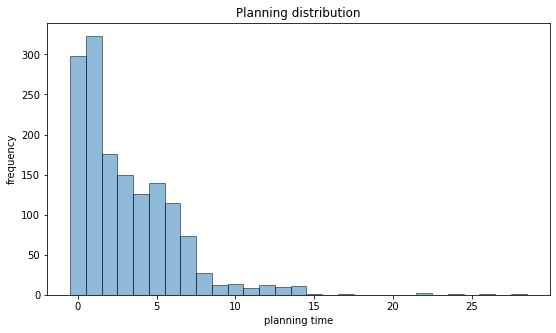

In [374]:
plt.figure(figsize=[9,5])
bins = range(0,30)

y = df_plan[target_y]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('planning time')
plt.ylabel('frequency')
plt.title('Planning distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [375]:
# quantiles
np.quantile(df_plan[target_y], [0.25,0.5,0.75])

array([1., 2., 5.])

In [376]:
# 0-1, class 0; 2-5, class 1, >5, class 2
df_train.loc[df_train[target_y] <=1, 'PlanGroup'] = 0
df_train.loc[(df_train[target_y] <=4)&(df_train[target_y]>=2), 'PlanGroup'] = 1
df_train.loc[df_train[target_y] >=5, 'PlanGroup'] = 2
df_train = df_train.drop(columns=[target_y])

df_test.loc[df_test[target_y] <=1, 'PlanGroup'] = 0
df_test.loc[(df_test[target_y] <=4)&(df_test[target_y]>=2), 'PlanGroup'] = 1
df_test.loc[df_test[target_y] >=5, 'PlanGroup'] = 2
df_test = df_test.drop(columns=[target_y])


In [377]:
X_train = df_train.drop('PlanGroup', axis=1).values
y_train = df_train['PlanGroup'].values

X_test = df_test.drop('PlanGroup', axis=1).values
y_test = df_test['PlanGroup'].values
feature_names = df_train.drop('PlanGroup', axis=1).columns.tolist()

In [378]:
### simple Random Forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rf2 = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf2.fit(X_train,y_train)

y_pred = clf_rf2.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46578366445916114


In [379]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 40, 60],
    'max_features': [4, 5, 6, 7, 8],
    'min_samples_leaf': [4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 12, 15],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [380]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


#best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 40, 60],
                         'max_features': [4, 5, 6, 7, 8],
                         'min_samples_leaf': [4, 5, 6, 7, 8],
                         'min_samples_split': [5, 10, 12, 15],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [381]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 4,
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 200}

In [382]:
best_grid = grid_search.best_estimator_

In [383]:
grid_search.score(X_test, y_test)

0.4768211920529801

In [384]:
y_rf_pred=grid_search.predict(X_test)
cm_rf = confusion_matrix(y_test, y_rf_pred)
print(cm_rf)
print(classification_report(y_test, y_rf_pred))

[[125  21  46]
 [ 56  24  54]
 [ 33  27  67]]
              precision    recall  f1-score   support

         0.0       0.58      0.65      0.62       192
         1.0       0.33      0.18      0.23       134
         2.0       0.40      0.53      0.46       127

    accuracy                           0.48       453
   macro avg       0.44      0.45      0.43       453
weighted avg       0.46      0.48      0.46       453



#### Planning rules

In [385]:
a = df_plan[df_plan['Planning']<=1]['Planning']
print(np.percentile(a, 90))
b = df_plan[(df_plan['Planning']<=4)&(df_plan['Planning']>=2)]['Planning']
print(np.percentile(b, 90))
c = df_plan[df_plan['Planning']>=6]['Planning']
print(np.percentile(c, 75))

1.0
4.0
9.0


#### rmse # days

In [386]:
y_pred_days = []
for i in y_rf_pred:
    if i == 0:
        y_pred_days.append(1)
    if i == 1:
        y_pred_days.append(4)       
    if i == 2:
        y_pred_days.append(8)
        
y_true_days = df_test_copy[target_y].values
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred_days, y_true_days,squared=False)
print(rmse)


5.024223881065017


In [ ]:
#df_new = df_new.reindex(columns=df_new.columns | df_train.columns)
#df_new.fillna(0, inplace=True)
#df_new = df_new[bi_features]

In [129]:
X_new = df_new.values
y_new_pred = grid_search.predict(X_new)
y_new_days = []
for i in y_new_pred:
    if i == 0:
        y_new_days.append(1)
    if i == 1:
        y_new_days.append(4)       
    if i == 2:
        y_new_days.append(9)
df_ins['Plan'] = y_new_days

In [132]:
df_ins['PretrtDays']=df_ins['Plan']+df_ins['Contour']
df_ins.head()

,MRN,CreatedDay,SiteGroup,Sitegroup_y,Intent,Category,priority weight,CTApptDuration,CT,TltDose,TxFracs,TrtDurations,pretrtDays,LINACs,Contour,Plan,PretrtDays
0,501606,0,CNS,CNS,Curative,Urgent 2,1.0,30,"2, 3",6000,30,30,2.0,"12, 16, 17",1,9,10
1,553742,0,Head & Neck,ENT (HEAD & NECK),Curative,Standard 3,0.5,45,"2, 3, 4",7000,35,15,3.0,"4,1,3",4,9,13
2,876982,0,Gynae,GYNAE,Palliative,Standard 3,0.5,30,4,3000,10,15,1.0,"9, 10, 15",1,4,5
3,2112215,0,Breast,BREAST,Adjuvant,Standard 3,0.5,30,"2, 3",4240,16,15,NaN,"5,7,8,11,6",4,9,13
4,2417776,0,Gynae,GYNAE,Adjuvant,Standard 3,0.5,15,"2,4",4500,25,20,NaN,"9,10,15",4,4,8


In [133]:
df_ins.to_excel("ins_20200109.xlsx")


In [136]:
df1920[df1920['Team']==1][['SimLocation','TxUnit']]

,SimLocation,TxUnit
337,CTSim3,SV03
1000,CTSim3,SA04
1041,CTSim2,EV06
1257,CTSim2,NA09
1342,CTSim3,SV03
...,...,...
56674,CTSim4,EA08
57275,CTSim3,SA04
57558,CTSim4,NA12
57592,CTSim2,SV01
